In [119]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
import pandas as pd
import pylab as plt
import pystan
import seaborn as sns
import numpy as np
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

![](../assets/DJlogo_alpha.png?raw=true)<!-- .element height="80%" width="80%" -->

<http://www.DataJavelin.com>
## Dr Peter Hurley 

### The Eight Schools Problem:
Taken from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) Chapter 5

A study was performed for the Educational Testing Service to analyze the effects of special coaching programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

In [120]:
data = dict(J = 8, y = [28,  8, -3,  7, -1,  1, 18, 12], 
            sigma = [15, 10, 16, 11,  9, 11, 10, 18])

### Summary of problem:
We want to model the effect of coaching on tests. 
 * $J$ = number of schools
 * $y$ = estimated coaching effect
 * $\sigma$ = standard error of effect estimate 
 
 

## Two possible models
1. **Separate estimates**
2. **Pooled estimate**

### Separate estimates
There is actuallly a difference in coaching effect at each school

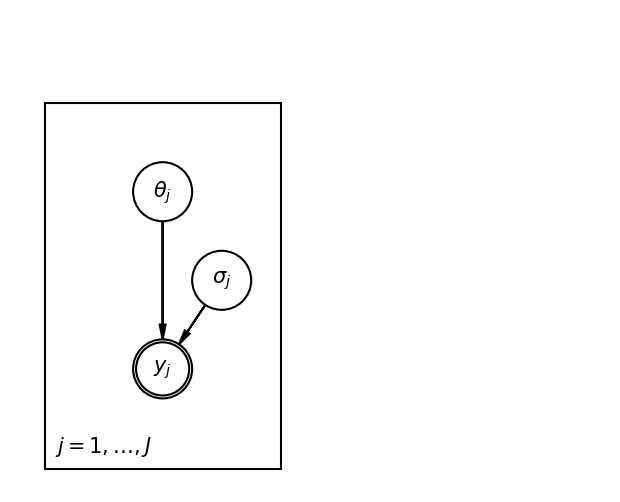

In [121]:
import daft
pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

# Parameters
pgm.add_node("theta",r"$\theta_j$",1.25,2.5)

# Noise
pgm.add_node('sigma',r"$\sigma_j$",1.75,1.75)

# Data.
pgm.add_node("y", r"$y_j$", 1.25, 1, observed=True)


pgm.add_edge('theta','y')
pgm.add_edge('sigma','y')


pgm.add_plate([0.25,0.25,2,3],label=r"$j = 1, \ldots, J$", shift=-0.1)
# Render and save.
pgm.render()
pgm.show()

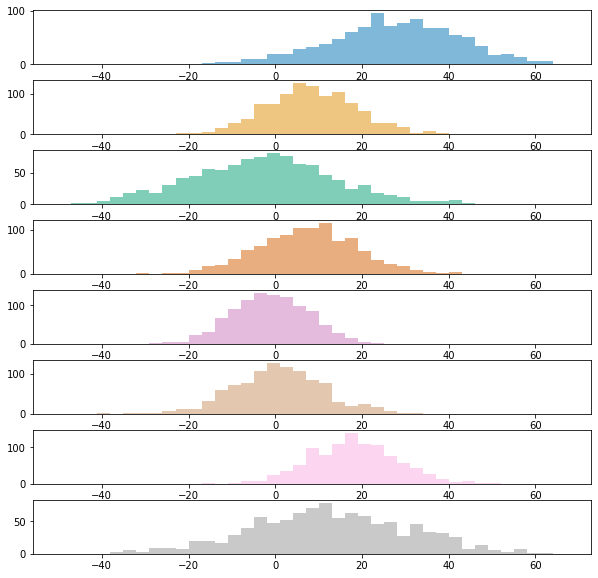

In [122]:
cmap= sns.color_palette('colorblind')
fig,axes=plt.subplots(data['J'],1,figsize=(10,10))
for i in range(0,data['J']):
    axes[i].hist(np.random.normal(data['y'][i],data['sigma'][i],1000),bins=np.arange(-50,70,3),color=cmap[i],alpha=0.5)
plt.subplots_adjust(hspace=0.3)

### Complete Pooling
Coaching has exactly the same effect at every school

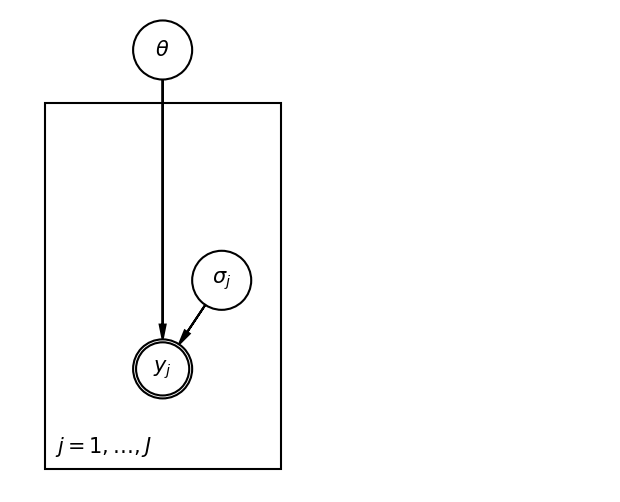

In [123]:
import daft
pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

# Parameters
pgm.add_node("theta",r"$\theta$",1.25,3.7)

# Noise
pgm.add_node('sigma',r"$\sigma_j$",1.75,1.75)

# Data.
pgm.add_node("y", r"$y_j$", 1.25, 1, observed=True)


pgm.add_edge('theta','y')
pgm.add_edge('sigma','y')


pgm.add_plate([0.25,0.25,2,3],label=r"$j = 1, \ldots, J$", shift=-0.1)
# Render and save.
pgm.render()
pgm.show()

### Complete pooling model

$$\theta \sim \mathcal{N}(0, 20)$$
$$y_{j} \sim \mathcal{N}(\theta, \sigma_{j})$$

In [125]:
complete_pooling ="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real theta;
}

model {
theta ~normal(0,20);
  y ~ normal(theta, sigma);
}

generated quantities {
real y_pred[J];
for (i in 1:J){
y_pred[i]=normal_rng(theta,sigma[i]);
}
}
"""

In [126]:
sm1=pystan.StanModel(model_code=complete_pooling)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76d36ff824b935580ef32b9dbbdf5aa7 NOW.


In [127]:
fit1=sm1.sampling(data=data)

In [128]:
fit1

Inference for Stan model: anon_model_76d36ff824b935580ef32b9dbbdf5aa7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta       7.36     0.1   3.87  -0.34   4.71   7.35   9.96  15.04   1465    1.0
y_pred[1]   7.25    0.25  15.38 -23.15  -3.08   7.27  17.47  37.43   3925    1.0
y_pred[2]   7.31    0.18  10.57 -13.55   0.29   7.39  14.49  28.24   3273    1.0
y_pred[3]   7.46    0.28  16.47 -25.35  -3.72   7.62  18.74  39.63   3445    1.0
y_pred[4]   7.57     0.2   11.8 -16.12  -0.44   7.57  15.72  29.99   3374    1.0
y_pred[5]   7.47    0.17   9.66 -11.27   0.83   7.49   14.1  26.51   3100    1.0
y_pred[6]   7.33    0.21  11.77 -15.86  -0.68   7.57  15.15  30.56   3192    1.0
y_pred[7]   7.31    0.19  10.77 -13.84   0.08   7.22  14.65  28.69   3272    1.0
y_pred[8]   7.27    0.31  18.22 -27.87  -5.14   7.56  19.15  43.37   3373    1.0
l

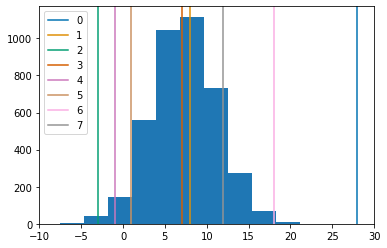

In [129]:
plt.hist(fit1['theta'])
for i in range(0,data['J']):
    plt.axvline(x=data['y'][i],color=cmap[i],label=str(i))
plt.xlim(-10,30)
plt.legend()

### Hierarchical_model
A good comprimise between the two extreme models which:
* combines information from all eight schools
* does not assume all the $\theta_j$'s to be equal

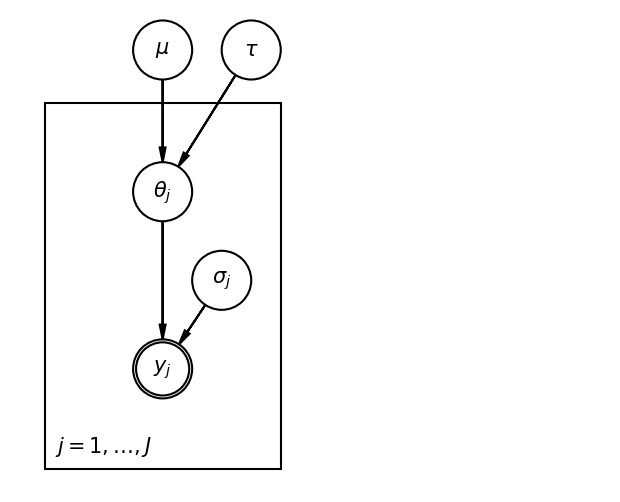

In [130]:
import daft
pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

# Parameters
pgm.add_node("mu",r"$\mu$",1.25,3.7)
pgm.add_node("tau",r"$\tau$",2.0,3.7)

pgm.add_node('theta',r'$\theta_j$',1.25,2.5)
# Noise
pgm.add_node('sigma',r"$\sigma_j$",1.75,1.75)

# Data.
pgm.add_node("y", r"$y_j$", 1.25, 1, observed=True)


pgm.add_edge('mu','theta')
pgm.add_edge('tau','theta')
pgm.add_edge('sigma','y')
pgm.add_edge('theta','y')

pgm.add_plate([0.25,0.25,2,3],label=r"$j = 1, \ldots, J$", shift=-0.1)
# Render and save.
pgm.render()
pgm.show()

### First attempt at Hierarchical model

$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\theta_{j} \sim \mathcal{N}(\mu, \tau)$$
$$y_{j} \sim \mathcal{N}(\theta_{j}, \sigma_{j})$$

**Exercise**: Build and fit Stan model

In [131]:
hier_1 ="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

In [132]:
sm=pystan.StanModel(model_code=hier_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6e11919b5314121a277ebece94b64d05 NOW.


In [133]:
fit=sm.sampling(data=data)

In [134]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

### Divergences: Try non-centred parameterisation
**Exercise** Write Stan model with the non-centred parameterisation

Hint: 
$$\theta_j = \mu + \tau * \tilde{\theta}$$

$$\tilde{\theta} \sim \mathcal{N}(0,1)$$

In [144]:
hier_2="""data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 2);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

In [145]:
sm2=pystan.StanModel(model_code=hier_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ae25ed61fa554e6cce98022baff80f2 NOW.


In [150]:
fit_nc=sm2.sampling(data=data,control=dict(adapt_delta=0.98))

In [151]:
pystan.check_hmc_diagnostics(fit_nc)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [152]:
fit_nc

Inference for Stan model: anon_model_2ae25ed61fa554e6cce98022baff80f2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.49    0.04   3.18   -1.9   2.37   4.48   6.65  10.69   5830    1.0
tau               2.2    0.03    2.3   0.06   0.64   1.49   2.93   8.55   4471    1.0
theta_tilde[1]   0.19    0.01   1.04  -1.83  -0.53    0.2   0.91    2.2   5423    1.0
theta_tilde[2]   0.06    0.01   0.96  -1.82  -0.59   0.07   0.71    1.9   5619    1.0
theta_tilde[3]  -0.05    0.01   0.97  -1.93  -0.71  -0.04   0.62   1.83   6458    1.0
theta_tilde[4]   0.04    0.01   0.99   -1.9  -0.63   0.03   0.73   1.93   6473    1.0
theta_tilde[5]  -0.12    0.01   0.97  -2.02  -0.75  -0.13   0.53   1.77   5809    1.0
theta_tilde[6]  -0.06    0.01   0.96  -1.92  -0.73  -0.05    0.6   1.83   5557    1.0
theta_tilde[7]   0.25    0.01    1.0 